## Detrending a Simulated Dataset 
For this question, you will be provided a sample time series that exhibits a trend and seasonality. 
Your goal is to remove both of these components to produce a stationary series.


In [ ]:
# This code was used to generate the original dataset; 
import numpy as np
np.random.seed(1234)
x_vals = np.arange(0, 200)
quad_trend = x_vals ** 2 * 0.004 + 0.2 * x_vals
seasonality = 2 * (x_vals % 5 == 0) + 3 * (x_vals % 5 == 1) + 1 * (x_vals % 5 == 2) - 1 * (x_vals % 5 == 4)
random_noise = np.random.normal(size=len(x_vals))
y_vals = quad_trend + seasonality + random_noise

In [ ]:
x = x_vals.reshape(-1,1)
y = y_vals.reshape(-1,1)

### Download and plot the time series 

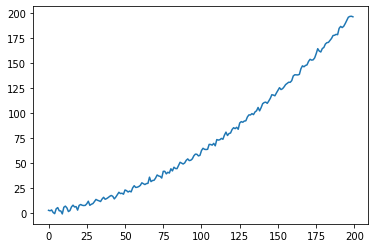

In [ ]:
# No need to change this code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# frame = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/simulated.csv')
# x = frame['x'].values.reshape(-1,1)
# y = frame['y'].values.reshape(-1,1)
plt.plot(x, y)

### Linear Trend
First, fit a line to the data. I recommend using `sklearn.linear_model.LinearRegression`, look [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for the user guide.


[[0.99416153]]


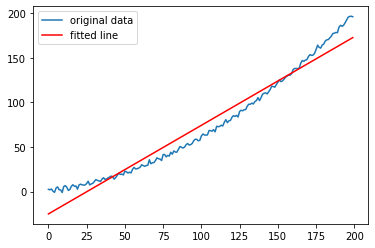

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(x, y)
print(clf.coef_) # Print the beta values found via regression 
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()

Now, find and plot the residuals. Is there a clear pattern? 

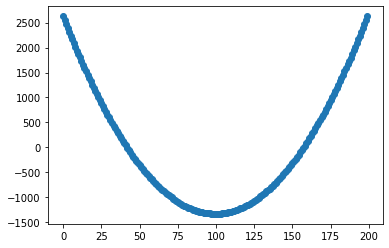

In [ ]:
linear_residuals = y - y_hat
plt.plot(x, linear_residuals,'o')

### Remove Linear Trend with First Differences
Remember that your end result will be one period shorter than your original data. 

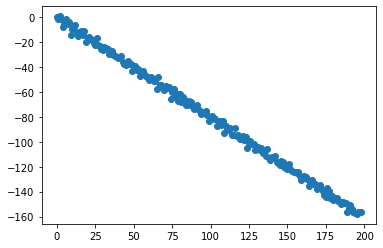

In [ ]:
first_diff = y[:-1] - y[1:]
plt.plot(x[:-1],first_diff, 'o')

### Fit and Remove Nonlinear Trend
Based on the residual plots, see if there is any further modification needed to the data to remove any trend. 
Apply this transformation and get the detrended dataset. 


[[0.20268991 0.00397724]]


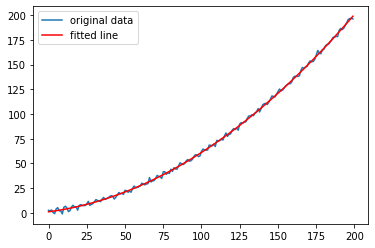

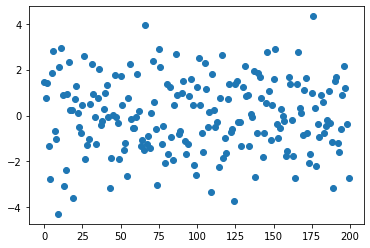

In [ ]:
# Hint: to combine two numpy series, you can use the np.hstack command 
new_x = np.hstack((x, x**2))
clf.fit(new_x, y)
quadratic_y_hat = clf.predict(new_x)
print(clf.coef_) # Print the beta values found via regression 
plt.plot(x, y, label='original data')
plt.plot(x, quadratic_y_hat, 'r', label='fitted line')
plt.legend()
plt.show()
nonlinear_residuals = y - quadratic_y_hat
plt.plot(x, nonlinear_residuals,'o');

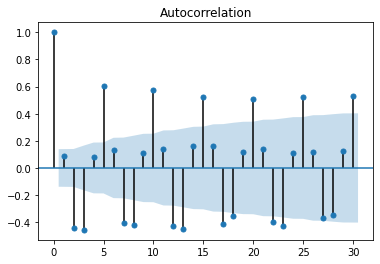

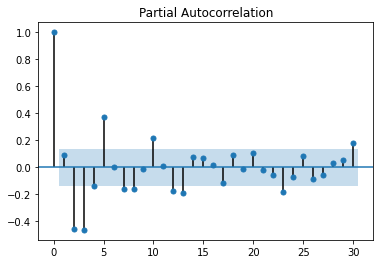

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(nonlinear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(nonlinear_residuals, lags=30)
plt.show()

## Removing Seasonal Component 
Find the periodicity of the database - we'll cover some more formal ways to investigate this. For now, we'll just zoom in on the pattern and visually inspect the periodicity.

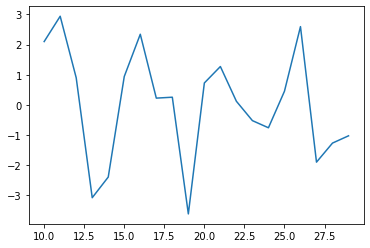

In [ ]:
start_point = 10
num_points = 20
plt.plot(x[start_point:start_point + num_points],nonlinear_residuals[start_point:start_point + num_points])

### Sinusoidal Approximation
Here, we use an optimization package to find the best sinusoidal approximation to this pattern. 

[1.72666351e+00 4.65270530e+00 3.56604067e-06]


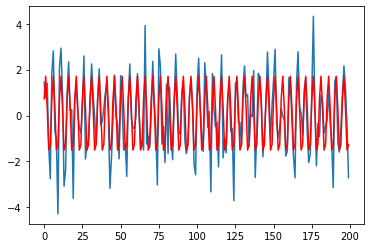

0.8077307074792506


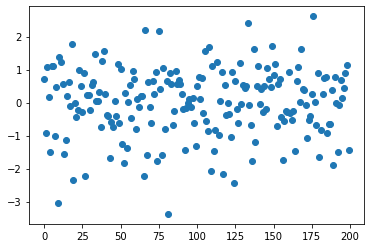

In [ ]:
from scipy import optimize
freq = 5
def sine_function(X, amp, phase_shift, mean):
  return (amp * np.sin(1/freq * 2 * np.pi * (X - phase_shift)) + mean)
params, _ = sine_curve_fit = optimize.curve_fit(
  f = sine_function,
  xdata = x.flatten(),
  ydata = nonlinear_residuals.flatten(),
  p0 = np.array([3, 1, 10]))
print(params)
amp, phase_shift, mean = params
sin_approx = sine_function(x, amp, phase_shift, mean)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, sin_approx, 'r', label='fitted line')
plt.plot()
plt.show()
sin_residuals = nonlinear_residuals - sin_approx
plt.plot(x, sin_residuals,'o');
print(np.mean(np.abs(sin_residuals)))

### Another approach: time-series fixed effects

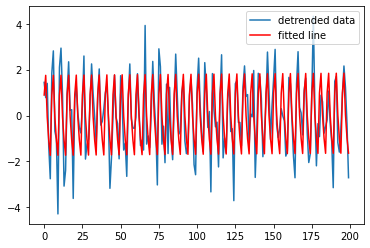

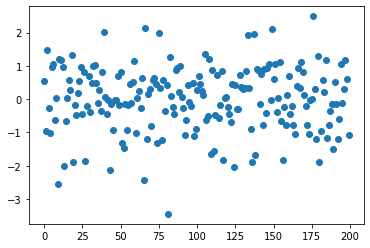

In [ ]:
period = 5
x_with_fixed_effects = x
for i in range(period):
  x_with_fixed_effects = np.hstack((x_with_fixed_effects, (x % period)==i))
clf.fit(x_with_fixed_effects, nonlinear_residuals)
fixed_effects_predicted = clf.predict(x_with_fixed_effects)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, fixed_effects_predicted, 'r', label='fitted line')
plt.legend();
plt.plot()
plt.show()
fixed_effects_residuals = nonlinear_residuals - fixed_effects_predicted
plt.plot(x, fixed_effects_residuals, 'o')

### Use Statsmodels to Detrend
For comparison, use Statsmodels package to remove
these same terms. See how this handles these packages. 

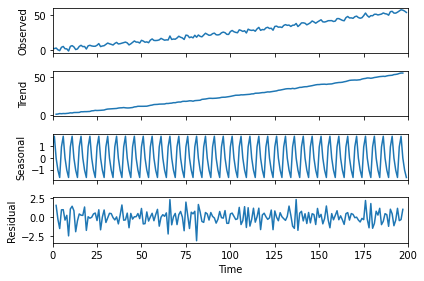

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(y, freq=5)
statsmodels_residuals = res.resid
res.plot()
plt.show()

In [ ]:
# plt.plot(x, detrended, label='detrended data')
for residual, label in zip([linear_residuals, nonlinear_residuals, sin_residuals, fixed_effects_residuals, statsmodels_residuals], 
                         ['linear', 'nonlinear', 'sinusoidal', 'fixed effects', 'statsmodels']):
  print('Mean squared error with {} method is: {}'.format(label, np.nanmean((residual)**2)))

Mean squared error with linear method is: 3.8109079019016447
Mean squared error with nonlinear method is: 2.546057730656277
Mean squared error with sinusoidal method is: 1.0553712224082998
Mean squared error with fixed effects method is: 0.937850418688958
Mean squared error with statsmodels method is: 0.800683561929778
